### LOADING DATASET

In [ ]:
!pip install pandas transformers datasets


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 14.0 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


### Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


### Loading Dataset

In [ ]:
import pandas as pd

# Path to the CSV file in Google Drive
file_path = '/content/drive/MyDrive/Datasets/Yelp_boba_Reviews_Cleaned.csv'

# Load the dataset
data = pd.read_csv(file_path)

# Display the first few rows of the dataframe
print(data.head())

# Check basic information about the dataset
print(data.info())


                   store        date     username         user_loc  \
0  bar-pa-tea-new-york-2  11/29/2020     Casey W.     New York, NY   
1  bar-pa-tea-new-york-2   8/13/2020     Marie R.    Edgewater, NJ   
2  bar-pa-tea-new-york-2   7/21/2020   Mariama K.  Los Angeles, CA   
3  bar-pa-tea-new-york-2   6/25/2020      Veon C.   Washington, DC   
4  bar-pa-tea-new-york-2   6/14/2020  Jessleen C.     Flushing, NY   

          rating                                            reviews  \
0  5 star rating  - absolutely one of my favorite ice cream plac...   
1  1 star rating  My experience was really bad. I'm usually a bu...   
2  3 star rating  Good but not amazing. Staff was not very frien...   
3  5 star rating  One of the best boba I've ever had. I usually ...   
4  5 star rating  I saw this place everyone on my timeline and h...   

                                             cleaned  \
0  ['absolutely', 'one', 'favorite', 'ice', 'crea...   
1  ['experience', 'really', 'bad', 'usua

### PREPROCESS THE DATA

In [ ]:
# Drop rows where 'cleaned_text' is null
data = data.dropna(subset = ['cleaned_text'])

# Optionally, convert ratings to a simpler format if needed
data['rating'] = data['rating'].apply(lambda x: int(x[0]))  # Converts '5 star rating' to 5


Define and Process Labels

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch

# Here 'data' is the DataFrame and 'sentiment' is the column for labels
labels = data['sentiment'].factorize()[0]  # Converts categorical to numerical codes


### TOKENIZATION

In [ ]:
from transformers import BertTokenizer

# Load a pre-trained tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


# Correctly tokenize the text
tokenized_data = data['cleaned_text'].apply(lambda x: tokenizer(x, truncation = True, padding = 'max_length', max_length = 512, return_tensors = 'pt'))

# Example to convert tokenized_data to a list of dictionaries suitable for dataset creation
def convert_to_dataset_friendly_format(tokenized_texts):
    # Initialize lists to store the outputs
    input_ids = []
    attention_masks = []

    # For each tokenized text, extract input_ids and attention_mask
    for tt in tokenized_texts:
        input_ids.append(tt['input_ids'].squeeze(0))  # Remove batch dimension
        attention_masks.append(tt['attention_mask'].squeeze(0))

    return {
        'input_ids': input_ids,
        'attention_mask': attention_masks
    }

# Convert tokenized_data, which is a series of dicts, to the correct format
processed_data = convert_to_dataset_friendly_format(tokenized_data)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

### Dataset Splitting, Creation and Setup

In [ ]:
# Performing the split
train_texts, val_texts, train_labels, val_labels = train_test_split(processed_data['input_ids'], labels, test_size = 0.1, random_state = 42)
train_masks, val_masks = train_test_split(processed_data['attention_mask'], test_size = 0.1, random_state = 42)


Dataset Creation

In [ ]:
from torch.utils.data import Dataset
import torch

# Custom dataset class for handling Yelp reviews
class YelpDataset(Dataset):
    """
    A custom PyTorch Dataset class designed to handle the Yelp reviews dataset.

    Args:
    - encodings (list): Encoded text data (input IDs) from the tokenizer.
    - masks (list): Attention masks corresponding to the encodings to indicate padding.
    - labels (list): Target labels associated with each review.

    Attributes:
    - encodings (list): Stores the tokenized text data.
    - masks (list): Stores the attention masks.
    - labels (list): Stores the labels of the reviews.
    """

    def __init__(self, encodings, masks, labels):
        """
        Initializes the YelpDataset with the provided data.

        Args:
        - encodings (list): The encoded representation of the reviews.
        - masks (list): Attention masks for handling padding in reviews.
        - labels (list): Classification labels for the reviews.
        """
        self.encodings = encodings
        self.masks = masks
        self.labels = labels

    def __getitem__(self, idx):
        """
        Retrieves an item from the dataset at a specified index.

        Args:
        - idx (int): The index of the item to retrieve.

        Returns:
        - dict: A dictionary containing the input IDs, attention masks, and label for the model.
        """
        item = {
            'input_ids': torch.tensor(self.encodings[idx], dtype=torch.long),
            'attention_mask': torch.tensor(self.masks[idx], dtype=torch.long),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }
        return item

    def __len__(self):
        """
        Returns the total number of items in the dataset.

        Returns:
        - int: The number of items in the dataset.
        """
        return len(self.labels)

# Create datasets for training and validation using pre-processed data
train_dataset = YelpDataset(train_texts, train_masks, train_labels)
val_dataset = YelpDataset(val_texts, val_masks, val_labels)



DataLoader Setup

In [ ]:
# Define the DataLoader
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = 16, shuffle = False)


### BERT Model Setup

Loading a pre-trained BERT model from Hugging Face's transformers library, tailored for sequence classification, which fits the sentiment analysis task.

In [ ]:
from transformers import BertForSequenceClassification, AdamW

# Load BERT for sequence classification with the number of unique labels (e.g., 2 for binary classification)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels = len(set(labels)))

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

Define Training Arguments

Setting up the training parameters such as the number of epochs, learning rate, and other necessary training configurations.

In [ ]:
# !pip install transformers[torch] -U


In [ ]:
!pip install accelerate -U

In [ ]:
import torch

# Check if CUDA is available and identify the GPU
if torch.cuda.is_available():
    print(f"CUDA is available! Running on GPU: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available. Running on CPU.")


CUDA is available! Running on GPU: NVIDIA L4


Setting Up Training Arguments

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir ='./results',
    num_train_epochs = 3,
    per_device_train_batch_size = 16,  # Adjust based on GPU RAM
    per_device_eval_batch_size = 64,   # Adjust based on GPU RAM
    warmup_steps = 500,
    weight_decay = 0.01,
    logging_dir = './logs',
    logging_steps = 10,
    evaluation_strategy = "steps",
    save_strategy = "steps",
    load_best_model_at_end = True,
    no_cuda = False,  # Explicitly allow CUDA usage
    fp16 = True,  # Enable mixed precision (fp16) to leverage Tensor Cores on Nvidia GPUs
)


Initialize the Model

In [ ]:
from transformers import BertForSequenceClassification

# Load BERT for sequence classification with the number of unique labels
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels = len(set(train_labels)))

# Move model to GPU if available
model.cuda()  # This ensures the model uses the GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

Initialize the Trainer

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model = model,                        # The instantiated 🤗 Transformers model to be trained
    args = training_args,                 # Training arguments, defined above
    train_dataset = train_dataset,        # Training dataset
    eval_dataset = val_dataset            # Evaluation dataset
)


Training

In [ ]:
trainer.train()


<ipython-input-8-7cb97a6c8f86>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {'input_ids': torch.tensor(self.encodings[idx]),
<ipython-input-8-7cb97a6c8f86>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'attention_mask': torch.tensor(self.masks[idx]),


Step,Training Loss,Validation Loss
10,0.974800,0.981415
20,0.900100,0.851975
30,0.801300,0.739366
40,0.651700,0.595290
50,0.609000,0.444852
60,0.439300,0.339921
70,0.372700,0.305114
80,0.335400,0.292817
90,0.227100,0.294927
100,0.285800,0.284950


<ipython-input-8-7cb97a6c8f86>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {'input_ids': torch.tensor(self.encodings[idx]),
<ipython-input-8-7cb97a6c8f86>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'attention_mask': torch.tensor(self.masks[idx]),
<ipython-input-8-7cb97a6c8f86>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {'input_ids': torch.tensor(self.encodings[idx]),
<ipython-input-8-7cb97a6c8f86>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sou

TrainOutput(global_step=2232, training_loss=0.20753962856360234, metrics={'train_runtime': 3409.4741, 'train_samples_per_second': 10.461, 'train_steps_per_second': 0.655, 'total_flos': 9384466270104576.0, 'train_loss': 0.20753962856360234, 'epoch': 3.0})

### Compute Metrics Function for Multiclass Classification

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(preds, labels):
    """
    Compute performance metrics for prediction results against true labels.

    Args:
    - preds (np.array): Raw model predictions (logits or probabilities) for each class.
    - labels (np.array): True labels for each prediction.

    Returns:
    - dict: A dictionary containing computed metrics: accuracy, F1 score, precision, and recall.

    Note:
    - The function currently calculates metrics using the 'macro' average which treats all classes equally.
      This can be changed to 'micro' or 'weighted' for different averaging techniques.
    """

    # Convert raw predictions to class indices
    preds = np.argmax(preds, axis=1)

    # Calculate accuracy
    accuracy = accuracy_score(labels, preds)

    # Calculate precision, recall, and F1-score
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')

    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }


### Generate Predictions

In [ ]:
# Generate predictions for the validation set
val_predictions = trainer.predict(val_dataset)
val_preds = val_predictions.predictions
val_labels = val_predictions.label_ids



<ipython-input-8-7cb97a6c8f86>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {'input_ids': torch.tensor(self.encodings[idx]),
<ipython-input-8-7cb97a6c8f86>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'attention_mask': torch.tensor(self.masks[idx]),


Compute Metrics

In [ ]:
# Apply softmax to convert logits to probabilities
softmax = torch.nn.Softmax(dim = 1)
val_probs = softmax(torch.tensor(val_preds)).numpy()

# Compute metrics with the modified function
val_metrics = compute_metrics(val_probs, val_labels)
print("Validation Metrics:")
for key, value in val_metrics.items():
    print(f"{key}: {value}")


Validation Metrics:
accuracy: 0.9371688115064345
f1: 0.4782791772260048
precision: 0.9001801801801802
recall: 0.4306170953229777


### Confusion Matrics: Handling Multiclass Visualization

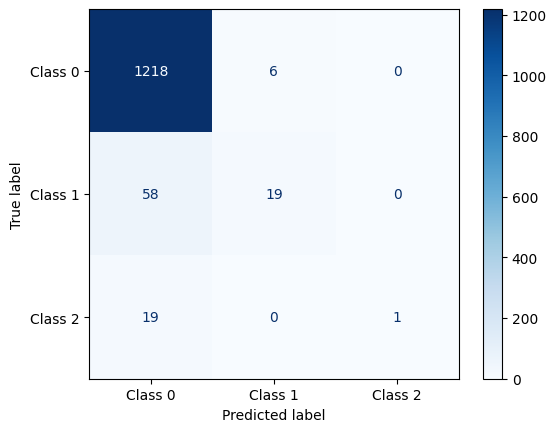

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_confusion_matrix(labels, preds, class_names):
    """
    Plots a confusion matrix for the given labels and predictions.

    Args:
    - labels (np.array): True labels for each sample.
    - preds (np.array): Raw model predictions (logits or probabilities) for each class.
    - class_names (list of str): List of class names corresponding to the labels.

    Description:
    - This function first converts raw prediction probabilities to class indices,
      computes the confusion matrix, and then displays it using Matplotlib.
    """

    # Convert raw predictions to class indices
    cm = confusion_matrix(labels, np.argmax(preds, axis=1))

    # Initialize the confusion matrix display
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    # Plot the confusion matrix using a blue color map
    disp.plot(cmap=plt.cm.Blues)

    # Show the plot
    plt.show()

# Example usage with class names specified
class_names = ['Class 0', 'Class 1', 'Class 2']  # Modify as per your class labels
plot_confusion_matrix(val_labels, val_probs, class_names)


In [ ]:
from transformers import Trainer
import numpy as np
import torch

# Here 'trainer' instance is from Hugging Face's Transformers
predictions = trainer.predict(val_dataset)
val_preds = predictions.predictions
val_labels = predictions.label_ids

# Apply softmax to convert logits to probabilities if your model outputs logits
softmax = torch.nn.Softmax(dim=1)
val_probs = softmax(torch.tensor(val_preds)).numpy()

# Convert probabilities to predicted class labels
predicted_labels = np.argmax(val_probs, axis=1)



<ipython-input-8-7cb97a6c8f86>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {'input_ids': torch.tensor(self.encodings[idx]),
<ipython-input-8-7cb97a6c8f86>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'attention_mask': torch.tensor(self.masks[idx]),


In [ ]:
from sklearn.metrics import classification_report

# val_labels are the true labels from the validation dataset
# and predicted_labels are the labels predicted by the model

# Print detailed classification report
print(classification_report(val_labels, predicted_labels, target_names=['Class 0', 'Class 1', 'Class 2']))


              precision    recall  f1-score   support

     Class 0       0.94      1.00      0.97      1224
     Class 1       0.76      0.25      0.37        77
     Class 2       1.00      0.05      0.10        20

    accuracy                           0.94      1321
   macro avg       0.90      0.43      0.48      1321
weighted avg       0.93      0.94      0.92      1321

